# <center/>优化数据准备的性能

## 概述

数据是整个深度学习中最重要的一环，因为数据的好坏决定了最终结果的上限，模型的好坏只是去无限逼近这个上限，所以高质量的数据输入，会在整个深度神经网络中起到积极作用，数据在整个数据处理和数据增强的过程像经过pipeline管道的水一样，源源不断地流向训练系统，如图所示：

![title](https://gitee.com/mindspore/docs/raw/master/tutorials/notebook/optimize_the_performance_of_data_preparation/images/pipeline.png)

MindSpore为用户提供了数据处理以及数据增强的功能，在数据的整个pipeline过程中，其中的每一步骤，如果都能够进行合理的运用，那么数据的性能会得到很大的优化和提升。本次体验将基于CIFAR-10数据集来为大家展示如何在数据加载、数据处理和数据增强的过程中进行性能的优化。

## 整体流程
- 准备环节。
- 数据加载性能优化。
- shuffle性能优化。
- 数据增强性能优化。
- 性能优化方案总结。

## 准备环节

### 导入模块

`dataset`模块提供API用来加载和处理数据集。

In [1]:
import mindspore.dataset as ds

`numpy`模块用于生成ndarray数组。

In [2]:
import numpy as np

### 下载所需数据集

1. 在jupyter工作目录下创建`./dataset/Cifar10Data`目录，本次体验所用的数据集存放在该目录下。
2. 在jupyter工作目录下创建`./transform`目录，本次体验转换生成的数据集存放在该目录下。
3. 下载[CIFAR-10二进制格式数据集](https://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz)，并将数据集文件解压到`./dataset/Cifar10Data/cifar-10-batches-bin`目录下，数据加载的时候使用该数据集。
4. 下载[CIFAR-10 Python文件格式数据集](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz)，并将数据集文件解压到`./dataset/Cifar10Data/cifar-10-batches-py`目录下，数据转换的时候使用该数据集。

目录结构如下所示：


    dataset/Cifar10Data
    ├── cifar-10-batches-bin
    │   ├── batches.meta.txt
    │   ├── data_batch_1.bin
    │   ├── data_batch_2.bin
    │   ├── data_batch_3.bin
    │   ├── data_batch_4.bin
    │   ├── data_batch_5.bin
    │   ├── readme.html
    │   └── test_batch.bin
    └── cifar-10-batches-py
        ├── batches.meta
        ├── data_batch_1
        ├── data_batch_2
        ├── data_batch_3
        ├── data_batch_4
        ├── data_batch_5
        ├── readme.html
        └── test_batch

其中：
- `cifar-10-batches-bin`目录为CIFAR-10二进制格式数据集目录。
- `cifar-10-batches-py`目录为CIFAR-10 Python文件格式数据集目录。

## 数据加载性能优化

MindSpore为用户提供了多种数据加载方式，其中包括常用数据集加载、用户自定义数据集加载、MindSpore数据格式加载，详情内容请参考[加载数据集](https://www.mindspore.cn/api/zh-CN/master/programming_guide/dataset_loading.html)。对于数据集加载，底层实现方式的不同，会导致数据集加载的性能存在差异，如下所示：

|      | 常用数据集 | 用户自定义 | MindRecord |
| :----: | :----: | :----: | :----: |
| 底层实现 | C++ | Python | C++ |
| 性能 | 高 | 中 | 高|

### 性能优化方案

![title](https://gitee.com/mindspore/docs/raw/master/tutorials/notebook/optimize_the_performance_of_data_preparation/images/data_loading_performance_scheme.png)

数据加载性能优化建议如下：
- 已经支持的数据集格式优选内置加载算子，具体内容请参考[内置加载算子](https://www.mindspore.cn/api/zh-CN/master/api/python/mindspore/mindspore.dataset.html)，如果性能仍无法满足需求，则可采取多线程并发方案，请参考本文[多线程优化方案](#多线程优化方案)。
- 不支持的数据集格式，优选转换为MindSpore数据格式后再使用`MindDataset`类进行加载，具体内容请参考[将数据集转换为MindSpore数据格式](https://www.mindspore.cn/api/zh-CN/master/programming_guide/dataset_conversion.html)，如果性能仍无法满足需求，则可采取多线程并发方案，请参考本文[多线程优化方案](#多线程优化方案)。
- 不支持的数据集格式，算法快速验证场景，优选用户自定义`GeneratorDataset`类实现，如果性能仍无法满足需求，则可采取多进程并发方案，请参考本文[多进程优化方案](#多进程优化方案)。

### 代码示例

基于以上的数据加载性能优化建议，本次体验分别使用内置加载算子`Cifar10Dataset`类、数据转换后使用`MindDataset`类、使用`GeneratorDataset`类进行数据加载，代码演示如下：

1. 使用内置算子`Cifar10Dataset`类加载CIFAR-10数据集，这里使用的是CIFAR-10二进制格式的数据集，加载数据时采取多线程优化方案，开启了4个线程并发完成任务，最后对数据创建了字典迭代器，并通过迭代器读取了一条数据记录。

In [3]:
cifar10_path = "./dataset/Cifar10Data/cifar-10-batches-bin/"

# create Cifar10Dataset for reading data
cifar10_dataset = ds.Cifar10Dataset(cifar10_path,num_parallel_workers=4)
# create a dictionary iterator and read a data record through the iterator
print(next(cifar10_dataset.create_dict_iterator()))

{'image': Tensor(shape=[32, 32, 3], dtype=UInt8, value=
      [[[235, 235, 235],
        [230, 230, 230],
        [234, 234, 234],
        ...,
        [248, 248, 248],
        [248, 248, 248],
        [249, 249, 249]],

       [[216, 216, 216],
        [213, 213, 213],
        [215, 215, 215],
        ...,
        [254, 254, 254],
        [253, 253, 253],
        [253, 253, 253]],

       [[213, 213, 213],
        [217, 217, 217],
        [215, 215, 215],
        ...,
        [255, 255, 255],
        [254, 254, 254],
        [254, 254, 254]],

       ...,

       [[195, 195, 195],
        [200, 200, 200],
        [202, 202, 202],
        ...,
        [138, 138, 138],
        [143, 143, 143],
        [172, 171, 176]],

       [[205, 205, 205],
        [205, 205, 205],
        [211, 211, 211],
        ...,
        [112, 112, 112],
        [130, 130, 132],
        [167, 163, 184]],

       [[210, 210, 210],
        [209, 209, 209],
        [213, 213, 213],
        ...,
        [120, 120,

2. 使用`Cifar10ToMR`这个类将CIFAR-10数据集转换为MindSpore数据格式，这里使用的是CIFAR-10 python文件格式的数据集，然后使用`MindDataset`类加载MindSpore数据格式数据集，加载数据采取多线程优化方案，开启了4个线程并发完成任务，最后对数据创建了字典迭代器，并通过迭代器读取了一条数据记录。

In [4]:
from mindspore.mindrecord import Cifar10ToMR

cifar10_path = './dataset/Cifar10Data/cifar-10-batches-py/'
cifar10_mindrecord_path = './transform/cifar10.record'

cifar10_transformer = Cifar10ToMR(cifar10_path,cifar10_mindrecord_path)
# executes transformation from Cifar10 to MindRecord
cifar10_transformer.transform(['label'])

# create MindDataset for reading data
cifar10_mind_dataset = ds.MindDataset(dataset_file=cifar10_mindrecord_path,num_parallel_workers=4)
# create a dictionary iterator and read a data record through the iterator
print(next(cifar10_mind_dataset.create_dict_iterator()))

{'data': Tensor(shape=[1431], dtype=UInt8, value= [255, 216, 255, ...,  63, 255, 217]), 'id': Tensor(shape=[], dtype=Int64, value= 30474), 'label': Tensor(shape=[], dtype=Int64, value= 2)}


3. 使用`GeneratorDataset`类加载自定义数据集，并且采取多进程优化方案，开启了4个进程并发完成任务，最后对数据创建了字典迭代器，并通过迭代器读取了一条数据记录。

In [5]:
def generator_func(num):
    for i in range(num):
        yield (np.array([i]),)

# create GeneratorDataset for reading data
dataset = ds.GeneratorDataset(source=generator_func(5),column_names=["data"],num_parallel_workers=4)
# create a dictionary iterator and read a data record through the iterator
print(next(dataset.create_dict_iterator()))

{'data': Tensor(shape=[1], dtype=Int64, value= [0])}


## shuffle性能优化

shuffle操作主要是对有序的数据集或者进行过repeat的数据集进行混洗，MindSpore专门为用户提供了`shuffle`函数，其中设定的`buffer_size`参数越大，混洗程度越大，但时间、计算资源消耗也会大。该接口支持用户在整个pipeline的任何时候都可以对数据进行混洗，具体内容请参考[shuffle处理](https://www.mindspore.cn/api/zh-CN/master/programming_guide/augmentation.html)。但是因为底层的实现方式不同，该方式的性能不如直接在[内置加载算子](https://www.mindspore.cn/api/zh-CN/master/api/python/mindspore/mindspore.dataset.html)中设置`shuffle`参数直接对数据进行混洗。

### 性能优化方案

![title](https://gitee.com/mindspore/docs/raw/master/tutorials/notebook/optimize_the_performance_of_data_preparation/images/shuffle_performance_scheme.png)

shuffle性能优化建议如下：
- 直接使用内置加载算子的`shuffle`参数进行数据的混洗。
- 如果使用的是`shuffle`函数，当性能仍无法满足需求，可通过调大`buffer_size`参数的值来优化提升性能。

### 代码示例

基于以上的shuffle性能优化建议，本次体验分别使用内置加载算子`Cifar10Dataset`类的`shuffle`参数和`Shuffle`函数进行数据的混洗，代码演示如下：

1. 使用内置算子`Cifar10Dataset`类加载CIFAR-10数据集，这里使用的是CIFAR-10二进制格式的数据集，并且设置`shuffle`参数为True来进行数据混洗，最后对数据创建了字典迭代器，并通过迭代器读取了一条数据记录。

In [6]:
cifar10_path = "./dataset/Cifar10Data/cifar-10-batches-bin/"

# create Cifar10Dataset for reading data
cifar10_dataset = ds.Cifar10Dataset(cifar10_path,shuffle=True)
# create a dictionary iterator and read a data record through the iterator
print(next(cifar10_dataset.create_dict_iterator()))

{'image': Tensor(shape=[32, 32, 3], dtype=UInt8, value=
      [[[254, 254, 254],
        [255, 255, 254],
        [255, 255, 254],
        ...,
        [232, 234, 244],
        [226, 230, 242],
        [228, 232, 243]],

       [[251, 251, 251],
        [253, 253, 254],
        [255, 255, 255],
        ...,
        [225, 227, 235],
        [227, 231, 241],
        [229, 233, 243]],

       [[250, 250, 250],
        [251, 251, 251],
        [253, 253, 253],
        ...,
        [233, 235, 241],
        [233, 236, 245],
        [238, 242, 250]],

       ...,

       [[ 67,  64,  71],
        [ 65,  62,  69],
        [ 64,  61,  68],
        ...,
        [ 71,  67,  70],
        [ 71,  68,  70],
        [ 69,  65,  68]],

       [[ 62,  58,  64],
        [ 59,  55,  61],
        [ 61,  58,  64],
        ...,
        [ 64,  62,  64],
        [ 61,  58,  59],
        [ 62,  60,  61]],

       [[ 66,  60,  65],
        [ 64,  59,  64],
        [ 66,  60,  65],
        ...,
        [ 64,  61,

2. 使用`shuffle`函数进行数据混洗，参数`buffer_size`设置为3，数据采用`GeneratorDataset`类自定义生成。

In [7]:
def generator_func():
    for i in range(5):
        yield (np.array([i,i+1,i+2,i+3,i+4]),)

ds1 = ds.GeneratorDataset(source=generator_func,column_names=["data"])
print("before shuffle:")
for data in ds1.create_dict_iterator():
    print(data["data"])

ds2 = ds1.shuffle(buffer_size=3)
print("after shuffle:")
for data in ds2.create_dict_iterator():
    print(data["data"])

before shuffle:
[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]
after shuffle:
[2 3 4 5 6]
[0 1 2 3 4]
[4 5 6 7 8]
[1 2 3 4 5]
[3 4 5 6 7]


## 数据增强性能优化

在图片分类的训练中，尤其是当数据集比较小的时候，用户可以使用数据增强的方式来预处理图片，从而丰富数据集。MindSpore为用户提供了多种数据增强的方式，其中包括：
- 使用内置C算子（`c_transforms`模块）进行数据增强。
- 使用内置Python算子（`py_transforms`模块）进行数据增强。
- 用户可根据自己的需求，自定义Python函数进行数据增强。

具体的内容请参考[数据增强](https://www.mindspore.cn/api/zh-CN/master/programming_guide/augmentation.html#id3)。因为底层的实现方式不同，所以性能还是有一定的差异，如下所示：

|   模块   | 底层接口 | 说明 |
| :----: | :----: | :----: |
| c_transforms | C++（基于OpenCV）| 性能高 |
| py_transforms | Python（基于PIL） | 该模块提供了多种图像增强功能，并提供了PIL Image和Numpy数组之间的传输方法 |


### 性能优化方案

![title](https://gitee.com/mindspore/docs/raw/master/tutorials/notebook/optimize_the_performance_of_data_preparation/images/data_enhancement_performance_scheme.png)


数据增强性能优化建议如下：
- 优先使用`c_transforms`模块进行数据增强，因为性能最高，如果性能仍无法满足需求，可采取[多线程优化方案](#多线程优化方案)、[Compose优化方案](#Compose优化方案)或者[算子融合优化方案](#算子融合优化方案)。
- 如果使用了`py_transforms`模块进行数据增强，当性能仍无法满足需求，可采取[多线程优化方案](#多线程优化方案)、[多进程优化方案](#多进程优化方案)、[Compose优化方案](#Compose优化方案)或者[算子融合优化方案](#算子融合优化方案)。
- `c_transforms`模块是在C++内维护buffer管理，`py_transforms`模块是在Python内维护buffer管理。因为Python和C++切换的性能成本，建议不要混用算子。
- 如果用户使用了自定义Python函数进行数据增强，当性能仍无法满足需求，可采取[多线程优化方案](#多线程优化方案)或者[多进程优化方案](#多进程优化方案)，如果还是无法提升性能，就需要对自定义的Python代码进行优化。

### 代码示例

基于以上的数据增强性能优化建议，本次体验分别使用`c_transforms`模块和自定义Python函数进行了数据增强，演示代码如下所示：

1. 使用`c_transforms`模块进行数据增强，数据增强时采用多线程优化方案，开启了4个线程并发完成任务，并且采用了算子融合优化方案，使用`RandomResizedCrop`融合类替代`RandomResize`类和`RandomCrop`类。

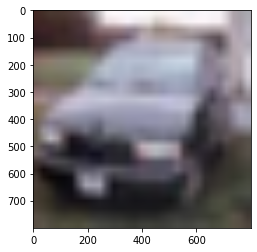

In [8]:
import mindspore.dataset.transforms.c_transforms as c_transforms
import mindspore.dataset.vision.c_transforms as C
import matplotlib.pyplot as plt
cifar10_path = "./dataset/Cifar10Data/cifar-10-batches-bin/"

# create Cifar10Dataset for reading data
cifar10_dataset = ds.Cifar10Dataset(cifar10_path,num_parallel_workers=4)
transforms = C.RandomResizedCrop((800,800))
# apply the transform to the dataset through dataset.map()
cifar10_dataset = cifar10_dataset.map(operations=transforms,input_columns="image",num_parallel_workers=4)

data = next(cifar10_dataset.create_dict_iterator())
plt.imshow(data["image"].asnumpy())
plt.show()

2. 使用自定义Python函数进行数据增强，数据增强时采用多进程优化方案，开启了4个进程并发完成任务。

In [9]:
def generator_func():
    for i in range(5):
        yield (np.array([i,i+1,i+2,i+3,i+4]),)

ds3 = ds.GeneratorDataset(source=generator_func,column_names=["data"])
print("before map:")
for data in ds3.create_dict_iterator():
    print(data["data"])

func = lambda x:x**2
ds4 = ds3.map(operations=func,input_columns="data",python_multiprocessing=True,num_parallel_workers=4)
print("after map:")
for data in ds4.create_dict_iterator():
    print(data["data"])

before map:
[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]
after map:
[ 0  1  4  9 16]
[ 1  4  9 16 25]
[ 4  9 16 25 36]
[ 9 16 25 36 49]
[16 25 36 49 64]


## 性能优化方案总结

### 多线程优化方案

在数据pipeline过程中，相关算子一般都有线程数设置参数，来提升处理并发度，提升性能，例如：
- 在数据加载的过程中，内置数据加载类有`num_parallel_workers`参数用来设置线程数。
- 在数据增强的过程中，`map`函数有`num_parallel_workers`参数用来设置线程数。
- 在Batch的过程中，`batch`函数有`num_parallel_workers`参数用来设置线程数。

具体内容请参考[内置加载算子](https://www.mindspore.cn/api/zh-CN/master/api/python/mindspore/mindspore.dataset.html)。

### 多进程优化方案

数据处理中Python实现的算子均支持多进程的模式，例如：
- `GeneratorDataset`这个类默认是多进程模式，它的`num_parallel_workers`参数表示的是开启的进程数，默认为1，具体内容请参考[GeneratorDataset](https://www.mindspore.cn/api/zh-CN/master/api/python/mindspore/mindspore.dataset.html#mindspore.dataset.GeneratorDataset)。
- 如果使用Python自定义函数或者`py_transforms`模块进行数据增强的时候，当`map`函数的参数`python_multiprocessing`设置为True时，此时参数`num_parallel_workers`表示的是进程数，参数`python_multiprocessing`默认为False，此时参数`num_parallel_workers`表示的是线程数，具体的内容请参考[内置加载算子](https://www.mindspore.cn/api/zh-CN/master/api/python/mindspore/mindspore.dataset.html)。

### Compose优化方案

Map算子可以接收Tensor算子列表，并将按照顺序应用所有的这些算子，与为每个Tensor算子使用的Map算子相比，此类“胖Map算子”可以获得更好的性能，如图所示：

![title](https://gitee.com/mindspore/docs/raw/master/tutorials/notebook/optimize_the_performance_of_data_preparation/images/compose.png)

### 算子融合优化方案

提供某些融合算子，这些算子将两个或多个算子的功能聚合到一个算子中。具体内容请参考[数据增强算子](https://www.mindspore.cn/api/zh-CN/master/api/python/mindspore/mindspore.dataset.vision.html)，与它们各自组件的流水线相比，这种融合算子提供了更好的性能。如图所示：

![title](https://gitee.com/mindspore/docs/raw/master/tutorials/notebook/optimize_the_performance_of_data_preparation/images/operator_fusion.png)